# Table of Contents
 <p><div class="lev1"><a href="#Data-Munging"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Munging</a></div><div class="lev1"><a href="#Correlations-between-Women-in-Parliament-and-Governance"><span class="toc-item-num">2&nbsp;&nbsp;</span>Correlations between Women in Parliament and Governance</a></div><div class="lev1"><a href="#Second-Law-of-Thermodynamics"><span class="toc-item-num">3&nbsp;&nbsp;</span>Second Law of Thermodynamics</a></div><div class="lev1"><a href="#Clustering"><span class="toc-item-num">4&nbsp;&nbsp;</span>Clustering</a></div><div class="lev1"><a href="#Modeling"><span class="toc-item-num">5&nbsp;&nbsp;</span>Modeling</a></div><div class="lev1"><a href="#Sensitivity-Analysis"><span class="toc-item-num">6&nbsp;&nbsp;</span>Sensitivity Analysis</a></div><div class="lev1"><a href="#Save-Timelapse-Data"><span class="toc-item-num">7&nbsp;&nbsp;</span>Save Timelapse Data</a></div>

In [130]:
%matplotlib inline
import numpy as np
import matplotlib
from matplotlib import pylab, mlab, pyplot as plt
from IPython.display import display
from IPython.core.pylabtools import figsize, getfigs
from sklearn.cluster import KMeans
from sklearn import svm
import pandas as pd
import math

# Data Munging

In [131]:
f = open('data/Governance 2004-2014.csv', 'r')
data = f.read().split('\n')
print(data[0])
print()
newData = []
for entry in data[1:]:
    dataEntry = entry.split(',')    
    if len(dataEntry) > 1 and 'EST' in dataEntry[3]:
        newData.append(dataEntry)
    
print(newData[0])

keys = []
for i in newData:
    if not i[3] in keys:
        keys.append(i[3])
print(keys)

codes = []
for i in newData:
    if not i[1] in codes:
        codes.append(i[1])
print(codes)

names = []
for i in newData:
    if not i[0] in names:
        names.append(i[0])
storedData = {}

storedData['rows'] = codes
storedData['names'] = names
storedData['cols'] = keys

for i in range(10):
    mtx = []
    num = 2005+i
    for n in range(0,len(newData),6):
        point = []
        for j in range(6):
            if newData[n+j][4+i] == '..':
                point.append(float('nan'))
            else:    
                point.append(float(newData[n+j][4+i]))
        mtx.append(point)

    storedData[num] = mtx
f.close()
govData = storedData

Country Name,Country Code,Series Name,Series Code,2005 [YR2005],2006 [YR2006],2007 [YR2007],2008 [YR2008],2009 [YR2009],2010 [YR2010],2011 [YR2011],2012 [YR2012],2013 [YR2013],2014 [YR2014]

['Afghanistan', 'AFG', 'Control of Corruption: Estimate', 'CC.EST', '-1.4642574787', '-1.4445164204', '-1.590514183', '-1.6371687651', '-1.5132791996', '-1.624465704', '-1.5496551991', '-1.4115658998', '-1.4301185608', '-1.331163168']
['CC.EST', 'GE.EST', 'PV.EST', 'RQ.EST', 'RL.EST', 'VA.EST']
['AFG', 'ALB', 'DZA', 'ASM', 'ADO', 'AGO', 'AIA', 'ATG', 'ARG', 'ARM', 'ABW', 'AUS', 'AUT', 'AZE', 'BHR', 'BGD', 'BRB', 'BLR', 'BEL', 'BLZ', 'BEN', 'BMU', 'BTN', 'BOL', 'BIH', 'BWA', 'BRA', 'BRN', 'BGR', 'BFA', 'BDI', 'CPV', 'KHM', 'CMR', 'CAN', 'CYM', 'CAF', 'TCD', 'CHL', 'CHN', 'COL', 'COM', 'COK', 'CRI', 'CIV', 'HRV', 'CUB', 'CYP', 'CZE', 'DNK', 'DJI', 'DMA', 'DOM', 'ECU', 'SLV', 'GNQ', 'ERI', 'EST', 'ETH', 'FJI', 'FIN', 'FRA', 'GUF', 'GAB', 'GEO', 'DEU', 'GHA', 'GRC', 'GRL', 'GRD', 'GUM', 'GTM', 'GIN', '

In [132]:
years = []
for k in govData.keys(): 
    if isinstance( k, ( int ) ): years.append(k)
years = sorted(years)
print(years)

[2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]


In [133]:
def generateObject(filename, startYear):
    f = open(filename, 'r')
    data = f.read().split('\n')
    f.close()

    newData = []
    
    for entry in data[1:]:
        dataEntry = entry.split(',')
        if len(dataEntry) > 4 and not dataEntry[3] == '':
            newData.append(dataEntry)
    keys = []
    for i in newData:
        if not i[3] in keys:
            keys.append(i[3])

    cnames = []
    for i in newData:
        if not i[0] in cnames:
            cnames.append(i[0])

    ccodes = []
    for i in newData:
        if not i[1] in ccodes:
            ccodes.append(i[1])
    data = {}
    
    data['rows'] = ccodes
    data['names'] = cnames
    data['cols'] = keys
    for i in range(len(newData[0][4:])):
        mtx = []
        num = startYear+i
        for n in range(0,len(newData),len(keys)):
            point = []
            for j in range(len(keys)):
                if newData[n+j][4+i] == '..':
                    point.append(float('nan'))
                else:
                    point.append(float(newData[n+j][4+i]))
            mtx.append(point)

        data[num] = mtx
    return data

In [134]:
popData = generateObject('data/Population_and_Jobs 2005-2014.csv',2005)
finData = generateObject('data/Finance 1991-2014.csv',1991)
healthData = generateObject('data/Health 1991-2014.csv',1991)

In [135]:
parliaDF = pd.read_csv('data/women_in_parliament.csv', sep=',')

renaming = dict()
for year in years + [2004]:
    renaming[ str(year) + ' [YR' + str(year) + ']' ] = year
renaming['\ufeffCountry Name'] = 'Country Name'

parliaDF = parliaDF.rename(index=str, columns=renaming)
for year in years + [2004]:
    vals = parliaDF[year].values
    vals[ vals == '..' ] = float('nan')
    parliaDF[year] = vals

In [136]:
parliaDF

,Country Name,Country Code,Series Name,Series Code,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,Afghanistan,AFG,Proportion of seats held by women in national ...,SG.GEN.PARL.ZS,NaN,27.3,27.3,27.7,27.7,27.3,27.7,27.7,27.7,27.7,27.7
1,Albania,ALB,Proportion of seats held by women in national ...,SG.GEN.PARL.ZS,6.4,7.1,7.1,7.1,7.1,16.4,16.4,15.7,15.7,17.9,20
2,Algeria,DZA,Proportion of seats held by women in national ...,SG.GEN.PARL.ZS,6.2,6.2,6.2,7.7,7.7,7.7,7.7,8,31.6,31.6,31.6
3,American Samoa,ASM,Proportion of seats held by women in national ...,SG.GEN.PARL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Andorra,ADO,Proportion of seats held by women in national ...,SG.GEN.PARL.ZS,14.3,28.6,28.6,28.6,25,35.7,35.7,50,50,50,50
5,Angola,AGO,Proportion of seats held by women in national ...,SG.GEN.PARL.ZS,15,15,15,15,37.3,38.6,38.6,38.2,34.1,34.1,36.8
6,Antigua and Barbuda,ATG,Proportion of seats held by women in national ...,SG.GEN.PARL.ZS,10.5,10.5,10.5,10.5,10.5,10.5,10.5,10.5,10.5,10.5,11.1
7,Arab World,ARB,Proportion of seats held by women in national ...,SG.GEN.PARL.ZS,6.7026706231454,7.0417823228634,9.35781922525108,9.76215634711929,9.81092517332058,9.91258880994672,11.9239257179875,11.3352657004831,14.8720183486239,17.49244456611,17.7939697133586
8,Argentina,ARG,Proportion of seats held by women in national ...,SG.GEN.PARL.ZS,33.7,36.2,35,40,40,38.5,38.5,37.4,37.4,NaN,36.6
9,Armenia,ARM,Proportion of seats held by women in national ...,SG.GEN.PARL.ZS,5.3,5.3,5.3,9.2,8.4,9.2,9.2,8.4,10.7,10.7,10.7


In [137]:
CountryCodeMap = dict()
for i in range(len(parliaDF)):
    CountryCodeMap[ parliaDF.iloc[i,1] ] = parliaDF.iloc[i,0]

In [138]:
def genDataFrames(dataBlob):
    DFs = dict()
    for c in range(len(dataBlob['cols'])):
        cname = dataBlob['cols'][c]
        DFs[cname] = pd.DataFrame()
        DFs[cname]['Country Code'] = dataBlob['rows']
        DFs[cname]['Country Name'] = dataBlob['names']
        for y in years:
            data = []
            for d in dataBlob[y]:
                data.append( d[c] )
            DFs[cname][y] = data
    return DFs

govDFs = genDataFrames(govData)
popDFs = genDataFrames(popData)
finanDFs = genDataFrames(finData)
healthDFs = genDataFrames(healthData)

# Correlations between Women in Parliament and Governance

In [139]:
def filterIntersection(df1, df2, field):
    goodSet = set( df1[field].values ) & set( df2[field].values )
    mask = df1[field].isin( goodSet )
    df1_ = df1.loc[mask]
    mask = df2[field].isin( goodSet )
    df2_ = df2.loc[mask]
    return df1_, df2_

In [140]:
def CorrelationCoeff(X,Y):
    mu_x = np.mean(X)
    mu_y = np.mean(Y)
    N = len(X)
    r = (sum([ X[i]*Y[i] for i in range(N) ]) - N*mu_x*mu_y) \
        / (math.sqrt( sum(X**2)-N*(mu_x**2) )) \
        / (math.sqrt( sum(Y**2)-N*(mu_y**2) ))
    return r

In [141]:
def plotCorrelation(df1, df2, xlabel, ylabel, plot_year, corrtimeplot_title):
    df1_, df2_ = filterIntersection( df1, df2, 'Country Code' )
    Rs = []
    
    for year in sorted(years):
        x = df1_[year].values
        x = np.array( x, dtype=float )
        x[ np.isnan(x) ] = 0
        x /= 100
        y = df2_[year].values
        y[ np.isnan(y) ] = 0
        y /= np.max(y)
        if (plot_year == year):
            plt.figure(1)
            plt.plot(x, y, '.')
            plt.title(year)
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)
        r = CorrelationCoeff(x, y)
        Rs.append(r)
    plt.figure(2)
    plt.plot( sorted(years), Rs )
    plt.title('Correlation over Time: ' + corrtimeplot_title)
    plt.xlabel('Year')
    plt.ylabel('Correlation Coefficient')
    return Rs

[0.27448172785237562,
 0.26988243434570475,
 0.27104585168713713,
 0.26417092692227989,
 0.22156435977007638,
 0.21918158082955261,
 0.21078953875132475,
 0.1583701295372956,
 0.15476193989908466,
 0.11588006005459639]

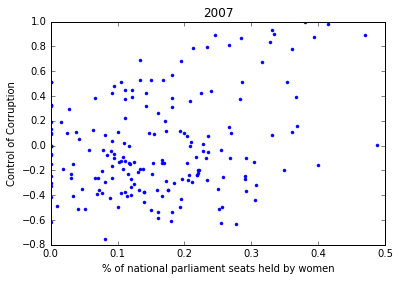

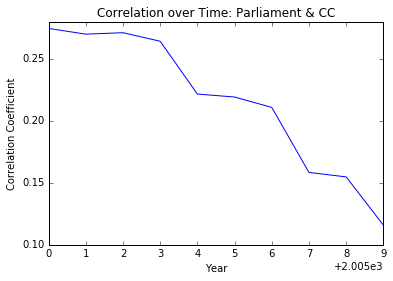

In [142]:
plotCorrelation( parliaDF, govDFs['CC.EST'], '% of national parliament seats held by women', 'Control of Corruption', 2007,
                 'Parliament & CC' )

[0.27922687793532014,
 0.25760927183492405,
 0.27982692683448218,
 0.27035025304550248,
 0.24999156384173554,
 0.23795254050813322,
 0.23602371919200993,
 0.19479444707327173,
 0.19365735548915036,
 0.19216367964509731]

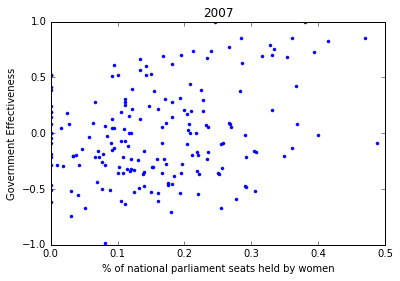

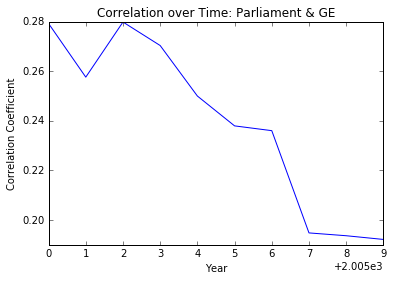

In [143]:
plotCorrelation( parliaDF, govDFs['GE.EST'], '% of national parliament seats held by women', 'Government Effectiveness', 2007,
                 'Parliament & GE' )

[0.11971453667525157,
 0.095422444391511291,
 0.098671640209537795,
 0.074174982111520474,
 0.065273120953872305,
 0.039380426167715775,
 0.062754530403709138,
 0.036444149233649525,
 0.037477296066047605,
 0.038063831458321054]

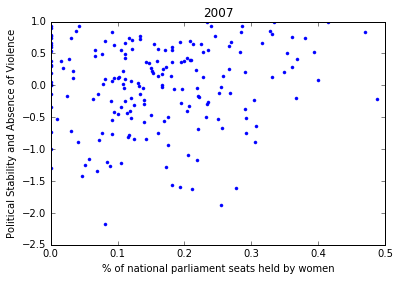

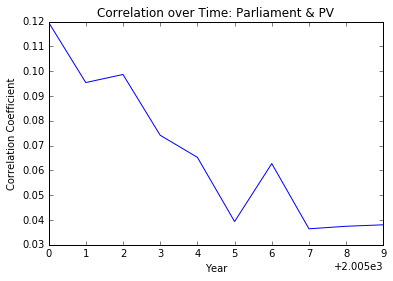

In [144]:
plotCorrelation( parliaDF, govDFs['PV.EST'], '% of national parliament seats held by women', 
                 'Political Stability and Absence of Violence', 2007, 'Parliament & PV' )

[0.19894663862709,
 0.17185378170013493,
 0.20203291858048336,
 0.21255667136434611,
 0.176071779177012,
 0.1657406212843647,
 0.16583353977175488,
 0.13116797041757372,
 0.146527933740809,
 0.10481912094228049]

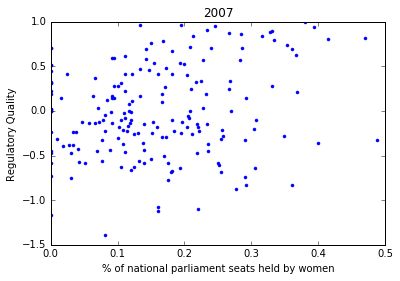

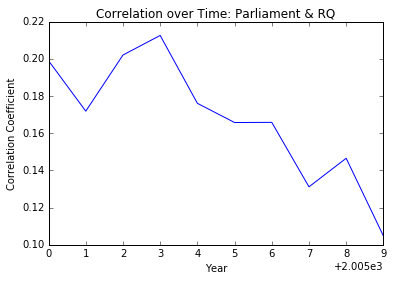

In [145]:
plotCorrelation( parliaDF, govDFs['RQ.EST'], '% of national parliament seats held by women', 'Regulatory Quality', 2007, 
                 'Parliament & RQ' )

[0.20372437197273852,
 0.15795972577767695,
 0.15305957145037943,
 0.14998965523810914,
 0.12834205809824792,
 0.11740773794336755,
 0.12403939177763591,
 0.085253501315293204,
 0.10045225718257499,
 0.11613317286716272]

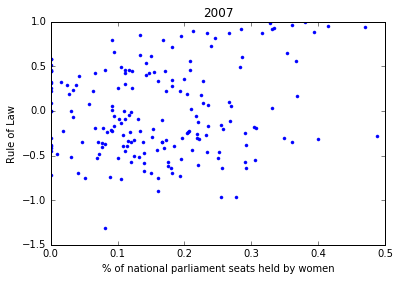

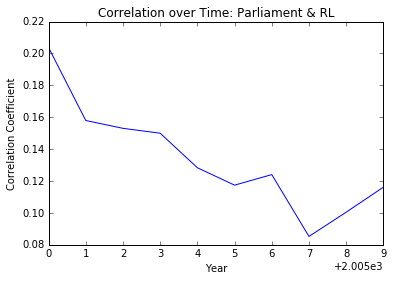

In [146]:
plotCorrelation( parliaDF, govDFs['RL.EST'], '% of national parliament seats held by women', 'Rule of Law', 2007, 
                 'Parliament & RL' )

[0.22756217850210814,
 0.18398375292608909,
 0.17320561525225855,
 0.16088340277823956,
 0.14284978841300322,
 0.1195856521556944,
 0.13510383238600987,
 0.11498736767432978,
 0.096423821778618038,
 0.092314425795584201]

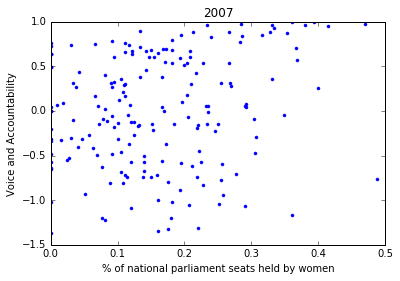

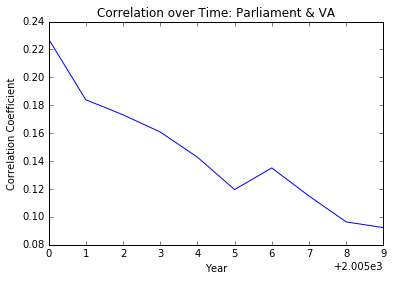

In [147]:
plotCorrelation( parliaDF, govDFs['VA.EST'], '% of national parliament seats held by women', 'Voice and Accountability', 2007, 
                 'Parliament & VA' )

# Second Law of Thermodynamics

In [148]:
def plotOverTime(df, name):
    for r in range(df.shape[0]):
        plt.plot(years, df.loc[r].values[2:])
        plt.title( name + ' Over Time' )
        plt.xlabel( 'Year' )
        plt.ylabel( name )

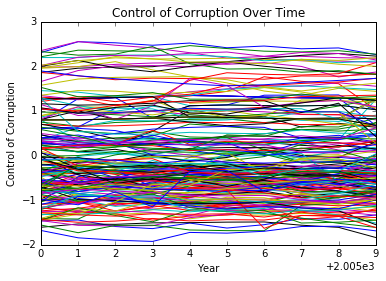

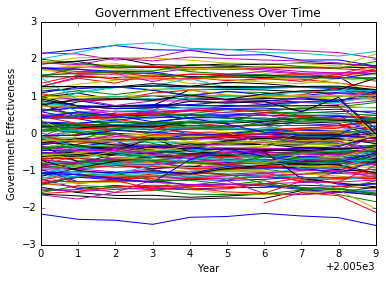

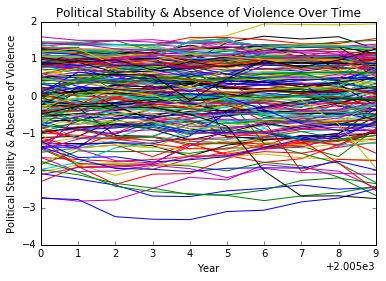

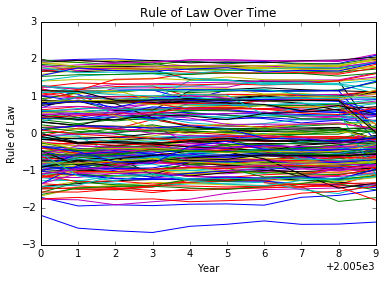

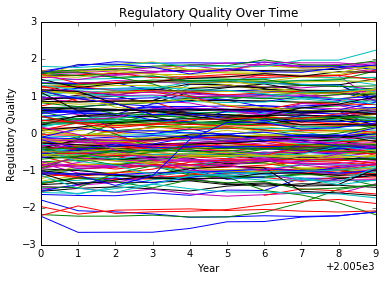

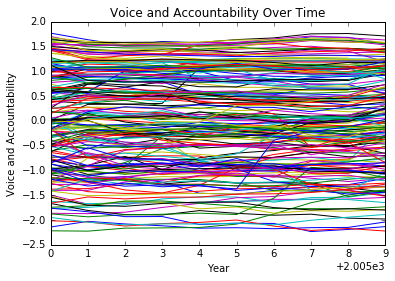

In [149]:
plt.figure(1)
plotOverTime( govDFs['CC.EST'], 'Control of Corruption' )
plt.figure(2)
plotOverTime( govDFs['GE.EST'], 'Government Effectiveness' )
plt.figure(3)
plotOverTime( govDFs['PV.EST'], 'Political Stability & Absence of Violence' )
plt.figure(4)
plotOverTime( govDFs['RL.EST'], 'Rule of Law' )
plt.figure(5)
plotOverTime( govDFs['RQ.EST'], 'Regulatory Quality' )
plt.figure(6)
plotOverTime( govDFs['VA.EST'], 'Voice and Accountability' )

# Clustering

In [150]:
def combineByYear(df_dicts):
    data = dict()
    for y in years:
        yearDF = pd.DataFrame()
        first = True
        for df in df_dicts:
            for key, df in df.items():
                df_, _ = filterIntersection( df, govDFs['CC.EST'], 'Country Code' )
                if (first):
                    yearDF['Country Name'] = df_['Country Name']
                    yearDF['Country Code'] = df_['Country Code']
                    first = False
                d = df_[ y ].values
                med = np.nanmedian( d )
                if (not np.isnan(med)):
                    d[ np.isnan(d) ] = med
                    yearDF[key] = d
        data[y] = yearDF
    return data

In [151]:
yearDFs = combineByYear([popDFs, finanDFs, healthDFs])

C:\Users\poegem\Anaconda2\envs\python3\lib\site-packages\numpy\lib\nanfunctions.py:689: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)


In [152]:
rseed = 24
k = 3
YEAR = 2013

X = yearDFs[YEAR].values[:,2:]
X = X.astype('double')
X /= X.max(axis=0)

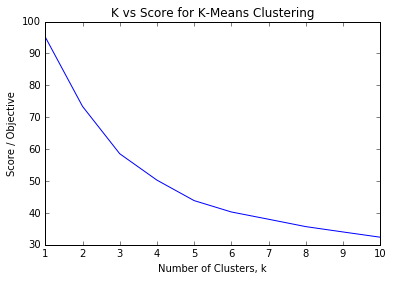

In [153]:
ks = range(1,11)
objs = np.ones((10,1))

for k in ks:
    KMeansClassifier = KMeans(n_clusters=k, random_state=rseed)
    KMeansClassifier.fit(X)
    objs[k-1] = KMeansClassifier.score(X) * -1

plt.plot(ks, objs)
plt.xlabel('Number of Clusters, k')
plt.ylabel('Score / Objective')
plt.title('K vs Score for K-Means Clustering')

In [154]:
k = 3
KMeansClassifier = KMeans(n_clusters=k, random_state=rseed)
y_pred = KMeansClassifier.fit_predict(X)

In [155]:
country_names = []
for c in yearDFs[YEAR]['Country Code'].values:
    n = parliaDF.loc[ parliaDF['Country Code'] == c ]['Country Name'].values[0]
    country_names.append( n )

print(country_names)

['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba', 'Australia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Cayman Islands', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czech Republic', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Greenland', 'Grenada', 'Guam', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iraq', 'Ireland', 'Israel

In [156]:
def saveToCSV(columns, filename):
    df = pd.DataFrame()
    for name,data in columns.items():
        df[name] = data
    df.to_csv(filename)

In [174]:
saveToCSV( {
        'Country': yearDFs[YEAR]['Country Name'].values,
        'Class': y_pred
        }, 'data/country_classes.csv')

# Modeling

In [158]:
class0 = yearDFs[YEAR].loc[ y_pred == 0 ]
class1 = yearDFs[YEAR].loc[ y_pred == 1 ]
class2 = yearDFs[YEAR].loc[ y_pred == 2 ]

parliaDF_0, _ = filterIntersection( parliaDF, class0, 'Country Code' )
parliaDF_1, _ = filterIntersection( parliaDF, class1, 'Country Code' )
parliaDF_2, _ = filterIntersection( parliaDF, class2, 'Country Code' )

[0.046123872008710355,
 0.042981720487550903,
 0.064895655955241119,
 0.065734194623702558,
 0.013428986253572601,
 0.0080122712816104447,
 0.046059195638796437,
 0.0019144346810486847,
 0.020189058178518328,
 -0.0018706011491390708]

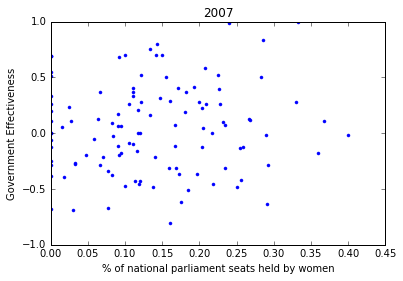

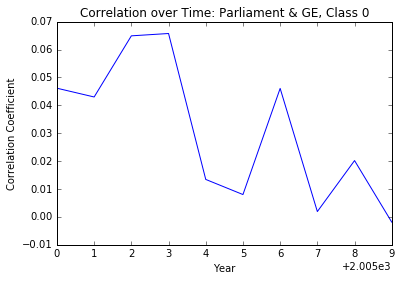

In [159]:
plotCorrelation( parliaDF_0, govDFs['GE.EST'], '% of national parliament seats held by women', 'Government Effectiveness', 2007,
                 'Parliament & GE, Class 0' )

[0.48883307302164142,
 0.41928421836429569,
 0.51089473874085356,
 0.37978304351467562,
 0.38972514146935239,
 0.38803001188761277,
 0.50869311714798437,
 0.48547380028881171,
 0.34389671760183188,
 0.27325980614927514]

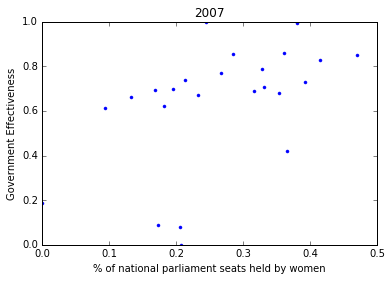

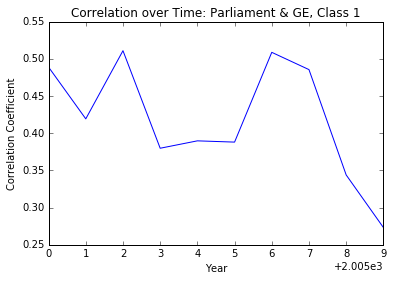

In [160]:
plotCorrelation( parliaDF_1, govDFs['GE.EST'], '% of national parliament seats held by women', 'Government Effectiveness', 2007,
                 'Parliament & GE, Class 1' )

[0.1046551389020564,
 0.16416261671789875,
 0.22014510207447077,
 0.26117837282913098,
 0.282997854166193,
 0.20159127999933249,
 0.28033836821964836,
 0.21494569486926748,
 0.25348025732901563,
 0.15978241748704078]

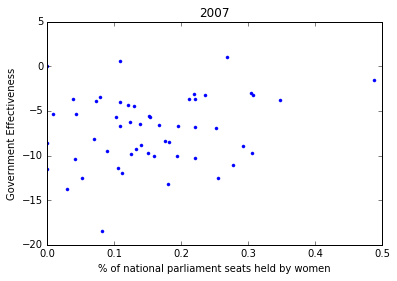

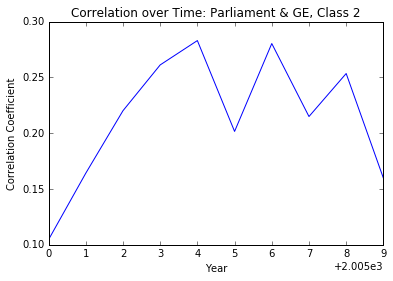

In [161]:
plotCorrelation( parliaDF_2, govDFs['GE.EST'], '% of national parliament seats held by women', 'Government Effectiveness', 2007,
                 'Parliament & GE, Class 2' )

[0.47665371087779829,
 0.46997619656383849,
 0.49102715826408716,
 0.48912578826509978,
 0.50126098860543156,
 0.51070795588622075,
 0.56423835979804071,
 0.55103898893077408,
 0.53476786667897391,
 0.53981644746076596]

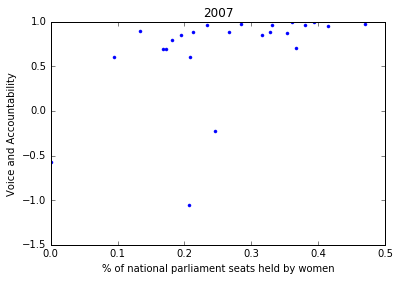

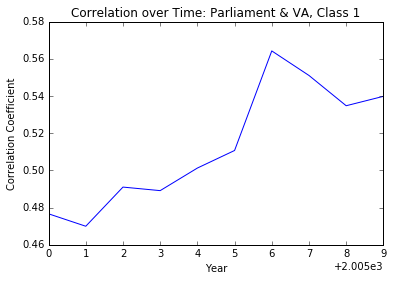

In [162]:
plotCorrelation( parliaDF_1, govDFs['VA.EST'], '% of national parliament seats held by women', 'Voice and Accountability', 2007,
                 'Parliament & VA, Class 1' )

In [163]:
def addSeries(df, series, df2, series2):
    df, df2 = filterIntersection( df, df2, 'Country Code' )
    vals = df[series].values
    df2[series2] = np.array( vals, dtype='double' )
    med = np.nanmedian( df2[series2].values )
    mask = np.isnan( df2[series2].values )
    df2.loc[mask, series2] = med
    return df2

def genModelData(dfx, dfy, seriesy):
    dfx, dfy = filterIntersection(dfx, dfy, 'Country Code')
    X = dfx.values[:,2:]
    X /= X.max(axis=0)
    y = np.array(dfy[seriesy].values)
    med = np.nanmedian(y)
    y[ np.isnan(y) ] = med
    return X,y

parlia_series_name = 'SG.GEN.PARL.ZS'
xDF = addSeries(parliaDF, YEAR, yearDFs[YEAR], parlia_series_name)

In [164]:
C = 10000.0
epsilon = 0.1
clf = svm.SVR(C=C, epsilon=epsilon)

X, y = genModelData( xDF, govDFs['GE.EST'], YEAR )

clf.fit(X, y)

print( clf.score(X, y) )

0.915606478251


In [165]:
C = 10000.0
epsilon = 0.1
clf_0 = svm.SVR(C=C, epsilon=epsilon)

xDF_0, _ = filterIntersection(xDF, class0, 'Country Code')
X0, y0 = genModelData( xDF_0, govDFs['GE.EST'], YEAR )

clf_0.fit(X0, y0)

print( clf_0.score(X0, y0) )

0.92249708582


In [166]:
C = 10000.0
epsilon = 0.1
clf_1 = svm.SVR(C=C, epsilon=epsilon)

xDF_1, _ = filterIntersection(xDF, class1, 'Country Code')
X1, y1 = genModelData( xDF_1, govDFs['GE.EST'], YEAR )

clf_1.fit(X1, y1)

print( clf_1.score(X1, y1) )

0.96327934337


In [167]:
C = 10000.0
epsilon = 0.1
clf_2 = svm.SVR(C=C, epsilon=epsilon)

xDF_2, _ = filterIntersection(xDF, class2, 'Country Code')
X2, y2 = genModelData( xDF_2, govDFs['GE.EST'], YEAR )

clf_2.fit(X2, y2)

print( clf_2.score(X2, y2) )

0.959460699013


# Sensitivity Analysis

In [168]:
def getSensitivity(clf, X, col, gamma):
    res = np.zeros((X.shape[0],1))
    for n in range(X.shape[0]):
        x0 = np.copy(X[n,:])
        y0 = clf.predict(x0)[0]
        x1 = np.copy(X[n,:])
        x1[col] += gamma
        y1 = clf.predict(x1)[0]
        res[n] = y1 - y0
    return res

In [169]:
gamma = 1 # one percent change

globalSens = getSensitivity(clf, X, -1, gamma)
class0Sens = getSensitivity(clf_0, X0, -1, gamma)
class1Sens = getSensitivity(clf_1, X1, -1, gamma)
class2Sens = getSensitivity(clf_2, X2, -1, gamma)

C:\Users\poegem\Anaconda2\envs\python3\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\poegem\Anaconda2\envs\python3\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\poegem\Anaconda2\envs\python3\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it cont

In [170]:
saveToCSV({
        'Country': xDF['Country Name'].values,
        'Value': np.ravel(globalSens)
    }, 'data/global_GE_sensitivity.csv')

saveToCSV({
        'Country': xDF_0['Country Name'].values,
        'Value': np.ravel(class0Sens)
    }, 'data/class0_GE_sensitivity.csv')

saveToCSV({
        'Country': xDF_1['Country Name'].values,
        'Value': np.ravel(class1Sens)
    }, 'data/class1_GE_sensitivity.csv')

saveToCSV({
        'Country': xDF_2['Country Name'].values,
        'Value': np.ravel(class2Sens)
    }, 'data/class2_GE_sensitivity.csv')

# Save Timelapse Data

In [171]:
for yr in years:
    saveToCSV({
            'Country': parliaDF['Country Name'].values,
            'Value': parliaDF[yr].values
        }, 'data/parliament_' + str(yr) + '.csv')

In [172]:
for yr in years:
    saveToCSV({
            'Country': govDFs['GE.EST']['Country Name'].values,
            'Value': govDFs['GE.EST'][yr].values
        }, 'data/gov_effectiveness_' + str(yr) + '.csv')

In [173]:
for yr in years:
    saveToCSV({
            'Country': govDFs['CC.EST']['Country Name'].values,
            'Value': govDFs['CC.EST'][yr].values
        }, 'data/gov_corruption_' + str(yr) + '.csv')